# Introduction

This is a simplification of my figuring out how to submit seqspec files to the IGVF DACC.

- [Python environment](#Setup)
- [Seqspec template function](#Template)
- [Working out steps needed to create seqspec objects](#Working-out-steps-needed-to-create-seqspec-objects)
- [Exploring boto3](#Exploring-boto3)
- [Seqspec submission functions](#Seqspec-Submission-functions)
- [Create seqspec objects for remaining fastqs](#Create-seqspec-objects-for-remaining-fastqs)

Information about barcodes.

cell barcode whitelists for 10x multiome GEX and ATAC:
- atac_737K-arc-v1.txt.gz
- gex_737K-arc-v1.txt.gz

MULTI-seq barcodes (custom)
- MULTIbc_onlist.txt 

MULTI-seq I7 indices (custom):
- index7_onlist_MULTI.txt 

10x Multiome 
- snRNA-seq I5 and I7 indices: https://cdn.10xgenomics.com/raw/upload/v1655151897/support/in-line%20documents/Dual_Index_Kit_TT_Set_A.csv
  - i7_dual_index_set_a.txt (10 bp)
  - i5_dual_index_set_a.txt (10 bp)
- ATAC-seq I7 indices: https://cdn.10xgenomics.com/raw/upload/v1655155348/support/in-line%20documents/Single_Index_Kit_N_Set_A.csv
  - i7_single_index_set_a.txt (8 bp)


# Setup

First we start with general imports

In [1]:
import gzip
import hashlib
from io import StringIO, BytesIO
import json
from jsonschema import Draft4Validator
import logging
import numpy
import os
import pandas
from pathlib import Path
import requests
import sys
import tarfile
from urllib.parse import urlparse
import yaml

In [2]:
try:
    import boto3
except ImportError:
    !{sys.executable} -m pip install --user boto3
    import boto3
    
from botocore.exceptions import ClientError
    

In [3]:
try:
    from jinja2 import Environment
except ImportError:
    !{sys.executable} -m pip install --user jinja2
    from jinja2 import Environment

from jinja2 import FileSystemLoader, select_autoescape, Undefined, StrictUndefined, make_logging_undefined



logger = logging.getLogger(__name__)
LoggingUndefined = make_logging_undefined(
    logger=logger,
    base=Undefined
)

env = Environment(
    loader=FileSystemLoader("templates"),
    autoescape=select_autoescape(),
    undefined=LoggingUndefined,
)

I want to be able to use the seqspec validator while I was writing my seqspec file.

I have the repository checked out into ~/proj/seqspec. This block should either import it for me, or install it if someone elese runs it.

In [4]:
try:
    import seqspec
except ImportError:
    seqspec_root = Path("~/proj/seqspec").expanduser()
    if seqspec_root.exists() and str(seqspec_root) not in sys.path:
        sys.path.append(str(seqspec_root))
    else:
        !{sys.executable} -m pip install --user seqspec
    import seqspec

Import pieces of seqspec that we need for this notebook.

In [5]:
from seqspec.Assay import Assay
from seqspec.Region import Region
from seqspec.Region import Onlist
from seqspec.utils import load_spec_stream
from seqspec.seqspec_index import run_index, get_index
from seqspec.seqspec_print import run_print_sequence_spec, run_print_library_tree, run_print_library_png
from seqspec.seqspec_onlist import run_list_onlists, run_onlist_read, run_find_by_type

I have my own API for interacting with the IGVF database server (which is very much like the old ENCODE database server)

In [6]:
try:
    from encoded_client import encoded
except ImportError:
    encoded_root = Path("~/proj/encoded_client").expanduser()
    if encoded_root.exists() and str(encoded_root) not in sys.path:
        sys.path.append(str(encoded_root))
    else:
        !{sys.executable} -m pip install --user encoded_client
        
    from encoded_client import encoded

encoded_client will pull submitter credentials from either DCC_API_KEY and DCC_SECRET_KEY or from a .netrc file loaded from your home directory. (replacing the {DCC_API_KEY} and {DCC_SECRET_KEY} strings with your specific values.)

The format of a .netrc file is a plain text file with records of the format:

<pre>machine api.sandbox.igvf.org login {DCC_API_KEY} password {DCC_SECRET_KEY}</pre>

Or api.data.igvf.org

(it's also possible to list the fields on separate lines, but I think it's easier to read when they're on one line)

or after creating the server object call:

<pre>server.username = "{DCC_API_KEY}"
server.password = "{DCC_SECRET_KEY}"</pre>



## submission variables

In [7]:
server_name = "api.sandbox.igvf.org"
#award = "/awards/HG012077/"
lab = "/labs/ansuman-satpathy/"

In [8]:
server = encoded.ENCODED(server_name)
igvf_validator = encoded.DCCValidator(server)

In [9]:
def get_read_lengths(accession, reads_to_check=100, verbose=False):
    url = "/sequence-files/{accession}/@@download/{accession}.fastq.gz".format(accession=accession)
    lengths = set()
    resp = server.get_response(url, stream=True)
    if resp.status_code == 200:
        with gzip.GzipFile(fileobj=resp.raw) as stream:
            for i, line in enumerate(stream):
                header = line.decode("utf-8").strip()
                sequence = stream.readline().decode("utf-8").strip()
                lengths.add(len(sequence))
                qual_header = stream.readline().decode("utf-8").strip()
                quality = stream.readline().decode("utf-8").strip()
                if verbose:
                    print(header)
                if i > reads_to_check:
                    break
    resp.close()
    return lengths


In [10]:
def seqspec_validate(schema, spec):
    """Validate a yaml object against a json schema
    """
    validator = Draft4Validator(schema)

    for idx, error in enumerate(validator.iter_errors(spec), 1):
        print(f"[{idx}] {error.message}")

In [11]:
schema_path = seqspec_root / "seqspec"/ "schema" / "seqspec.schema.json"

with open(schema_path, "rt") as instream:
    seqspec_schema = json.load(instream)

In [12]:
def load_spec(filename):
    with open(filename, "rt") as instream:
        data = yaml.load(instream, Loader=yaml.Loader)
        for r in data.assay_spec:
            r.set_parent_id(None)
    return data

# Template

First build up lists of barcodes onlists needed for this protocol the names will be passed to the template.

In [13]:
metadata = pandas.read_csv("mcginnis-spec-igvfid.csv")
metadata

,identifier,modality,sequence_kit,sequence_protocol,R1,R2,R3,I1,I2
0,ansuman-satpathy:igvf_exp9_rna_10x1_NGS1,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI89937990,TSTFI57715085,NaN,TSTFI53270550,TSTFI56758474
1,ansuman-satpathy:igvf_exp9_rna_10x1_NGS2,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI55582037,TSTFI06510279,NaN,TSTFI57008146,TSTFI00812906
2,ansuman-satpathy:igvf_exp9_rna_10x1_NGS3,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI32996705,TSTFI64269163,NaN,TSTFI40471526,TSTFI71696004
3,ansuman-satpathy:igvf_exp9_rna_10x2_NGS1,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI54717222,TSTFI82230687,NaN,TSTFI21834349,TSTFI71959057
4,ansuman-satpathy:igvf_exp9_rna_10x2_NGS2,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI72642771,TSTFI35688274,NaN,TSTFI02574524,TSTFI02792754
5,ansuman-satpathy:igvf_exp9_rna_10x2_NGS3,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI05820649,TSTFI02748302,NaN,TSTFI42884946,TSTFI74989609
6,ansuman-satpathy:igvf_exp9_rna_10x3_NGS1,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI78812910,TSTFI04921495,NaN,TSTFI18009559,TSTFI05038036
7,ansuman-satpathy:igvf_exp9_rna_10x3_NGS2,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI70293151,TSTFI28187770,NaN,TSTFI13239319,TSTFI14579365
8,ansuman-satpathy:igvf_exp9_rna_10x3_NGS3,rna,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI29766143,TSTFI95211429,NaN,TSTFI41342678,TSTFI09979856
9,ansuman-satpathy:igvf_exp9_multi_10x1_NGS1,multi,NovaSeq X Series 10B Reagent Kit,Illumina NovaSeq X,TSTFI91515525,TSTFI69017826,NaN,TSTFI91422283,TSTFI30201014


In [14]:
barcode_sets = {
    "rna": {
        "cell_barcode": "gex_737K-arc-v1.txt.gz",
        "cell_barcode_md5": "FIXME_cell_barcode_md5",
        "i7_dual_index": "i7_dual_index_set_a.txt",
        "i7_dual_index_md5": "FIXME_i7_dual_index_md5",
        "i5_dual_index": "i5_dual_index_set_a.txt", # could be reversed
        "i5_dual_index_md5": "FIXME_i5_dual_index_md5",
    },
    "atac": {
        "cell_barcode": "atac_737K-arc-V1.txt.gz",
        "cell_barcode_md5": "FIXME_cell_barcode_md5",
        "i7_single_index": "i7_single_index_set_a.txt",
        "i7_single_index_md5": "FIXME_i7_single_index_md5",
    },
    "multi": {
        "cell_barcode": "737K-august-2016.txt",
        "cell_barcode_md5": "f62a276e262fdd85262a889d0f48556b",
        "multi_barcode": "MULTIbc_onlist.txt",
        "multi_barcode_md5": "66d841ec290d6c93e4b02638f97f3c23",
        "i7_multi_index": "index7_onlist_MULTI.txt",
        "i7_multi_index_md5": "dea9fa960eb2f11b18d47f978c596a79",
    }
}


Define the the file information needed to define this seqspec.

In [15]:
# load the template and instantiate it with the context for this specific measurement set.
# this version needs the libspec branch that separates the sequence and library specifications

def create_seqspec(row, verbose=False):
    #template_name = "parse-wt-mega-v2-single-index-libspec-1.yaml.j2"
    modality = row["modality"]
    template_name = "igvf-multiseq-{modality}.yaml.j2".format(modality=modality)
    template = env.get_template(template_name)

    # Build context
    context = {}
    # Merge in the barcode information
    context.update(barcode_sets[modality])

    context.update(row.to_dict())

    for column in ["R1", "R2", "R3", "I1", "I2"]:
        if pandas.notnull(row[column]):
            lengths = get_read_lengths(row[column], reads_to_check=10)
            context[f"{column}_min_len"] = min(lengths)
            context[f"{column}_max_len"] = max(lengths)

    example_yaml = template.render(context)

    # validate the generated seqspec file.
    example_spec = load_spec_stream(StringIO(example_yaml))
    seqspec_validate(seqspec_schema, example_spec.to_dict())

    example_spec.update_spec()
    if verbose:
        print(example_spec.to_YAML())
    return example_spec

In [16]:
example_spec = create_seqspec(metadata[metadata["modality"] == "multi"].iloc[0])

In [21]:
print(example_spec.to_YAML())

!Assay
seqspec_version: 0.1.1
assay_id: 10x-ATAC-RNA-MULTI
name: 10x-ATAC-RNA-MULTI/Illumina
doi: https://doi.org/10.1038/s41592-019-0433-8
date: 17 June 2019
description: ansuman-satpathy:igvf_exp9_multi_10x1_NGS1 MULTI-seq
modalities:
- tag
lib_struct: https://igvf.github.io/seqspec/
library_protocol: Any
library_kit: Illumina Truseq Dual Index
sequence_protocol: Illumina NovaSeq X
sequence_kit: NovaSeq X Series 10B Reagent Kit
sequence_spec:
- !Read
  read_id: TSTFI91515525
  name: Read 1
  modality: tag
  primer_id: multi-truseq_read1
  min_len: 28
  max_len: 28
  strand: pos
- !Read
  read_id: TSTFI91422283
  name: Index 1 (i7 index)
  modality: tag
  primer_id: multi-truseq_read2
  min_len: 10
  max_len: 10
  strand: pos
- !Read
  read_id: TSTFI69017826
  name: Read 2
  modality: tag
  primer_id: multi-truseq_read2
  min_len: 90
  max_len: 90
  strand: neg
library_spec:
- !Region
  parent_id: null
  region_id: tag
  region_type: tag
  name: MULTI sample barcode
  sequence_type: j

In [17]:
print(run_print_library_tree(example_spec))

                                                    ┌─'MULTI-illumina_p5:29'
                                                    ├─'multi-truseq_read1:29'
                                                    ├─'barcode:16'
                                                    ├─'umi:12'
───────────────────────── ──tag─────────────────────┼─'random_spacer:100'
                                                    ├─'MULTI-seq barcode:8'
                                                    ├─'multi-truseq_read2:33'
                                                    ├─'MULTI-index7:8'
                                                    └─'MULTI-illumina_p7:24'


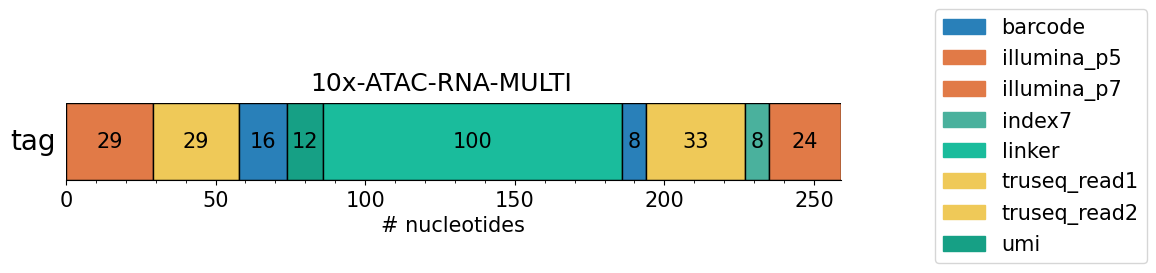

In [18]:
_ = run_print_library_png(example_spec)

In [19]:
def save_seqspecs_targz(table, destination):
    with tarfile.open(destination, "w:gz") as archive:
        for i, row in table.iterrows():
            row_name = row[0].replace("ansuman-satpathy:", "")
            print("Processing {}".format(row_name))
            spec = create_seqspec(row)
            spec_yaml = spec.to_YAML().encode("utf-8")
            spec_stream = BytesIO(spec_yaml)
            spec_filename = f"{row_name}_seqspec.yaml"
            spec_tarinfo = tarfile.TarInfo(str(spec_filename))
            spec_tarinfo.size = len(spec_yaml)
            archive.addfile(spec_tarinfo, fileobj=spec_stream)


def save_team_seqspecs_directory(destination, table):
    arguments = []
    raw_url = "https://raw.githubusercontent.com/detrout/y2ave_seqspecs/main/{filename}"
    
    for i, row in table.iterrows():
        row_name = row[0]
        print("Processing {} {}".format(team_id, row_name))
        spec_filename = f"{team_id}_{row_name}_seqspec.yaml"
        spec_yaml = render_seqspec(team_id, row)
        with open(destination/spec_filename, "wt") as outstream:
            outstream.write(spec_yaml)
            
        spec = load_spec_stream(StringIO(spec_yaml))
        arg_row = {
            "team_id": team_id,
            "dataset_id": row_name,
            "url": raw_url.format(filename=spec_filename),
        }
        print(generate_seqspec_index(spec, row))
        arg_row.update(generate_seqspec_index(spec, row))
        arguments.append(arg_row)

    return arguments



In [20]:
save_seqspecs_targz(metadata, "/dev/shm/mcginnis-test.tgz")

Processing igvf_exp9_rna_10x1_NGS1
[1] 'FIXME_i5_dual_index_md5' does not match '^[a-f0-9]{32}$'
[2] 'FIXME_cell_barcode_md5' does not match '^[a-f0-9]{32}$'
[3] 'FIXME_i7_dual_index_md5' does not match '^[a-f0-9]{32}$'
Processing igvf_exp9_rna_10x1_NGS2
[1] 'FIXME_i5_dual_index_md5' does not match '^[a-f0-9]{32}$'
[2] 'FIXME_cell_barcode_md5' does not match '^[a-f0-9]{32}$'
[3] 'FIXME_i7_dual_index_md5' does not match '^[a-f0-9]{32}$'
Processing igvf_exp9_rna_10x1_NGS3
[1] 'FIXME_i5_dual_index_md5' does not match '^[a-f0-9]{32}$'
[2] 'FIXME_cell_barcode_md5' does not match '^[a-f0-9]{32}$'
[3] 'FIXME_i7_dual_index_md5' does not match '^[a-f0-9]{32}$'
Processing igvf_exp9_rna_10x2_NGS1
[1] 'FIXME_i5_dual_index_md5' does not match '^[a-f0-9]{32}$'
[2] 'FIXME_cell_barcode_md5' does not match '^[a-f0-9]{32}$'
[3] 'FIXME_i7_dual_index_md5' does not match '^[a-f0-9]{32}$'
Processing igvf_exp9_rna_10x2_NGS2
[1] 'FIXME_i5_dual_index_md5' does not match '^[a-f0-9]{32}$'
[2] 'FIXME_cell_barcode